In [7]:
import pandas as pd
import numpy as np
import os
import yaml
import pickle
from sklearn.preprocessing import MinMaxScaler

In [12]:
RAW_DIR = "/home/dds/yjq/data/data-TrainTicket"
TARGET_DIR = '/home/dds/yjq/DejaVu/data/TrainTicket'
DATES = ["2024-11-01", "2024-11-02", "2024-11-03"]

In [100]:
def get_pod_service_name(target_date):
    pod_names = []
    service_names = []
    for file in os.listdir(os.path.join(RAW_DIR, target_date, "metric")):
        pod = file.split('.')[0]
        service = pod.split("service")[0]+"service"
        pod_names.append(pod)
        service_names.append(service)
    return pod_names, service_names

In [101]:
pod_names, service_names = get_pod_service_name(DATES[0])
print(len(pod_names))
print(len(service_names))

40
40


In [102]:
yaml_data = []
# 构造 YAML 数据结构
data1 = {
    "class": "global_params",
    "pod": pod_names,
    'service': service_names
}

## 处理节点

In [103]:
metrics = {
    "cpu": ["cpu"],
    "memory": ["memory"],
    "io": ["io"],
    "syscall" :["syscall_read","syscall_write"],
    "network": ["net_receive","net_send","net_latency"]
}

In [104]:
nodes_data = []
for metric, values in metrics.items():
    node_data = {
        "class": "node",
        "global_params": ["pod"],
        "id": r"{pod} "+metric,
        "metrics":[r'{pod}##'+name for name in values],
        "type": f"Pod {metric}"        
    }
    nodes_data.append(node_data)
nodes_data

[{'class': 'node',
  'global_params': ['pod'],
  'id': '{pod} cpu',
  'metrics': ['{pod}##cpu'],
  'type': 'Pod cpu'},
 {'class': 'node',
  'global_params': ['pod'],
  'id': '{pod} memory',
  'metrics': ['{pod}##memory'],
  'type': 'Pod memory'},
 {'class': 'node',
  'global_params': ['pod'],
  'id': '{pod} io',
  'metrics': ['{pod}##io'],
  'type': 'Pod io'},
 {'class': 'node',
  'global_params': ['pod'],
  'id': '{pod} syscall',
  'metrics': ['{pod}##syscall_read', '{pod}##syscall_write'],
  'type': 'Pod syscall'},
 {'class': 'node',
  'global_params': ['pod'],
  'id': '{pod} network',
  'metrics': ['{pod}##net_receive', '{pod}##net_send', '{pod}##net_latency'],
  'type': 'Pod network'}]

## 处理边

In [105]:
def get_edges_from_trace(target_date):
    edges = set()
    for file in os.listdir(os.path.join(RAW_DIR, target_date, "trace"))[:1]:
        trace_file = os.path.join(RAW_DIR, target_date, "trace", file)
        print(trace_file)
        trace_df = pd.read_csv(trace_file)
        trace_df.head()
        traceid_spans = {}
        for trace_id, trace_spans in trace_df.groupby('TraceID'):
            traceid_spans[trace_id] = trace_spans
            for spans in traceid_spans.values():
                for span1 in spans.iterrows():
                    span_id = span1[1]['SpanID']
                    service1 = span1[1]['PodName'].split("service")[0] + "service"
                    for span2 in spans.iterrows():
                        parent_id = span2[1]['ParentID']
                        if span_id == parent_id:
                            service2 = span2[1]['PodName'].split("service")[0] + "service"
                            if service1 != service2:
                                edges.add((service1, service2))
        return edges

In [106]:
edges = get_edges_from_trace(DATES[0])

/home/dds/yjq/data/data-TrainTicket/2024-11-01/trace/22_28_trace.csv


In [ ]:

dst = [edge[1] for edge in edges]
src = [edge[0] for edge in edges]
edge_data = {
    'class': 'edge',
    'dst': r'{dst}',
    'params': {
        'dst': dst,
        'src': src
    },
    'src': r'{src}',
    'type': 'service-service'
}

## 整合

In [ ]:
# 将 YAML 数据写入文件
yaml_data.append(data1)
yaml_data.extend(nodes_data)
yaml_data.append(edge_data)
with open("output.yaml", "w") as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False, sort_keys=False)
    print("YAML 文件已生成：output.yaml")

## 处理metric

In [50]:
with open('/home/dds/yjq/DejaVu/Data/D/metrics.norm.pkl', 'rb') as f:
    metric_data = pickle.load(f)

In [51]:
metric_data

,serviceName,timestamp,value,metric_kind,name,pod,metric_type
4189,ts-admin-basic-info-service,1645596000,0.390379,cost,ts-admin-basic-info-service##cost,NaN,cost
4190,ts-admin-basic-info-service,1645596060,0.371458,cost,ts-admin-basic-info-service##cost,NaN,cost
4191,ts-admin-basic-info-service,1645596120,-0.080145,cost,ts-admin-basic-info-service##cost,NaN,cost
4192,ts-admin-basic-info-service,1645596180,-0.069390,cost,ts-admin-basic-info-service##cost,NaN,cost
4193,ts-admin-basic-info-service,1645596240,-0.063645,cost,ts-admin-basic-info-service##cost,NaN,cost
...,...,...,...,...,...,...,...
58051597,NaN,1646510640,0.000000,succ_rate,ts-verification-code-service-1##succ_rate,ts-verification-code-service-1,succ_rate
58051598,NaN,1646510760,0.000000,succ_rate,ts-verification-code-service-1##succ_rate,ts-verification-code-service-1,succ_rate
58051599,NaN,1646510880,0.000000,succ_rate,ts-verification-code-service-1##succ_rate,ts-verification-code-service-1,succ_rate
58051600,NaN,1646510940,0.000000,succ_rate,ts-verification-code-service-1##succ_rate,ts-verification-code-service-1,succ_rate


In [58]:
processed_data = []
for dt in DATES:
    for file in sorted(os.listdir(os.path.join(RAW_DIR, "2024-11-01", "metric"))):
        pod_metric = pd.read_csv(os.path.join(RAW_DIR, "2024-11-01", "metric", file))
        pod = file.split('.')[0]
        service = pod.split("service")[0]+"service"
        pod_metric['time'] = pd.to_datetime(pod_metric['time'])
        # 将 datetime 对象四舍五入到最近的分钟
        pod_metric['time'] = pod_metric['time'].dt.floor('min')
        pod_metric['timestamp'] = pod_metric['time'].astype('int64') // 10**9 - 60 * 60 * 8  # 转换为秒级时间戳
        pod_metric['serviceName'] = service
        pod_metric = pod_metric.drop(columns=['time', 'run_time'])
        pod_metric.rename(columns={'pod_name':'pod'})

        metrics = ['cpu', 'memory', 'io', 'syscall_read', 'syscall_write', 'net_receive', 'net_send', 'net_latency']


        # 对每个指标进行处理
        for metric in metrics:
            # 选择当前指标列
            metric_df = pod_metric[['serviceName', 'timestamp', 'pod_name', metric]].copy()
            
            # 重命名列以符合输出格式
            metric_df = metric_df.rename(columns={metric: 'value'})
            metric_df['metric_kind'] = metric  # 假设这些指标都是 gauge 类型
            metric_df['name'] = metric_df.apply(lambda row: f"{row['pod_name']}##{metric}", axis=1)
            metric_df['pod'] = metric_df['pod_name']
            metric_df['metric_type'] = metric  # 同上
            
            # 删除不再需要的列
            metric_df = metric_df.drop(columns=['pod_name'])
            
            # 将处理后的数据添加到列表中
            processed_data.append(metric_df)

        # 将处理后的数据转换为 DataFrame
processed_df = pd.concat(processed_data, ignore_index=True)
processed_df.to_csv(os.path.join(TARGET_DIR, 'metrics.csv'), index=False)

In [59]:
# 按照 name 归一化
scaler = {}
for name, group in processed_df.groupby('name'):
    scaler[name] = MinMaxScaler()
    processed_df.loc[group.index, 'value'] = scaler[name].fit_transform(group[['value']])

# 打印处理后的 DataFrame
processed_df

,serviceName,timestamp,value,metric_kind,name,pod,metric_type
0,ts-admin-basic-info-service,1730451120,0.059664,cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6##cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6,cpu
1,ts-admin-basic-info-service,1730451180,0.065265,cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6##cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6,cpu
2,ts-admin-basic-info-service,1730451240,0.055786,cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6##cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6,cpu
3,ts-admin-basic-info-service,1730451300,0.062432,cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6##cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6,cpu
4,ts-admin-basic-info-service,1730451360,0.197233,cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6##cpu,ts-admin-basic-info-service-5f44d7855b-nrbk6,cpu
...,...,...,...,...,...,...,...
409915,ts-voucher-service,1730476500,0.000000,net_latency,ts-voucher-service-5658485d65-d44dx##net_latency,ts-voucher-service-5658485d65-d44dx,net_latency
409916,ts-voucher-service,1730476560,0.000000,net_latency,ts-voucher-service-5658485d65-d44dx##net_latency,ts-voucher-service-5658485d65-d44dx,net_latency
409917,ts-voucher-service,1730476620,0.000000,net_latency,ts-voucher-service-5658485d65-d44dx##net_latency,ts-voucher-service-5658485d65-d44dx,net_latency
409918,ts-voucher-service,1730476680,0.000000,net_latency,ts-voucher-service-5658485d65-d44dx##net_latency,ts-voucher-service-5658485d65-d44dx,net_latency


In [60]:
processed_df.to_csv(os.path.join(TARGET_DIR, 'metrics.norm.csv'), index=False)

In [63]:
with open(os.path.join(TARGET_DIR, 'metrics.norm.pkl'), 'wb') as f:
    pickle.dump(processed_df,f)

## 转换标签

In [8]:
import json
temp = []
for dt in DATES:
    label_json_file = os.path.join(RAW_DIR, dt, dt+'-fault_list.json')
    with open(label_json_file, 'r') as f:
        faults = json.load(f)
    temp.extend(faults.values())

In [9]:
fault_list = []
for tmp in temp:
    fault_list.extend(tmp)
fault_list

[{'inject_time': '2024-11-01 17:30:09',
  'inject_timestamp': '1730453409',
  'inject_pod': 'ts-contacts-service-6b9f8dcd78-m68rp',
  'inject_type': 'cpu_contention'},
 {'inject_time': '2024-11-01 17:42:21',
  'inject_timestamp': '1730454141',
  'inject_pod': 'ts-contacts-service-6b9f8dcd78-m68rp',
  'inject_type': 'network_delay'},
 {'inject_time': '2024-11-01 17:54:33',
  'inject_timestamp': '1730454873',
  'inject_pod': 'ts-contacts-service-6b9f8dcd78-m68rp',
  'inject_type': 'io_contention'},
 {'inject_time': '2024-11-01 18:06:42',
  'inject_timestamp': '1730455602',
  'inject_pod': 'ts-contacts-service-6b9f8dcd78-m68rp',
  'inject_type': 'network_loss'},
 {'inject_time': '2024-11-01 18:18:51',
  'inject_timestamp': '1730456331',
  'inject_pod': 'ts-contacts-service-6b9f8dcd78-m68rp',
  'inject_type': 'memory_stress'},
 {'inject_time': '2024-11-01 18:31:02',
  'inject_timestamp': '1730457062',
  'inject_pod': 'ts-basic-service-5958769c99-mj82d',
  'inject_type': 'cpu_contention'},


In [13]:
import csv
converted_data = []
for item in fault_list:
    timestamp = int(item['inject_timestamp'])
    duration = '3m'
    root_cause_node = item['inject_pod']
    experiment_type = item['inject_type'].replace('_', '-').replace('cpu', 'CPU').replace('network', 'pod-network')
    converted_data.append([timestamp, duration, root_cause_node, experiment_type])

# 写入CSV文件
csv_file = os.path.join(TARGET_DIR, 'faults.csv')
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['timestamp', 'duration', 'root_cause_node', 'experiment_type'])
    writer.writerows(converted_data)

In [3]:
import json
with open("/home/user/yjq/Dejavu-changed/data/TrainTicket/trainticket_split.json", "r") as f:
    split_json = json.load(f)
    

In [8]:
train_timestamp = [f['timestamp'] for f in split_json['train']]
test_timestamp = [f['timestamp'] for f in split_json['test']]

In [9]:
print(len(train_timestamp))
print(len(test_timestamp))

104
58


In [14]:
import pandas as pd
fault_df = pd.read_csv('./TrainTicket/gt/faults.csv')
train_list, validation_list, test_list = [], [], []
for idx, (_, fault) in enumerate(fault_df.iterrows()):
    t = fault['timestamp']
    flag = True
    for temp1 in train_timestamp:
        if t > temp1-120 and t < temp1 + 120:
            train_list.append(idx)
            flag = False
            break
    for temp1 in test_timestamp:
        if t > temp1-120 and t < temp1 + 120:
            test_list.append(idx)
            flag = False
            break
    if flag:
        validation_list.append(idx)
    
print(
f"{len(train_list)=} "
f"{len(set(train_list))=} "
f"{len(validation_list)=} "
f"{len(test_list)=} "
)

len(train_list)=104 len(set(train_list))=104 len(validation_list)=20 len(test_list)=58 


In [4]:
import os
import datetime

def rename_files_with_rounded_timestamp(directory):
    # 遍历指定目录下的所有文件
    for file_name in os.listdir(directory):
        # 检查文件扩展名是否为.yml
        if file_name.endswith('.yml'):
            # 提取时间戳部分
            base_name, extension = os.path.splitext(file_name)
            try:
                timestamp_str = base_name.split('_')[-1]
                # 将字符串转换为整数时间戳
                timestamp = int(timestamp_str)
                
                # 将时间戳转换为datetime对象
                dt = datetime.datetime.fromtimestamp(timestamp)
                
                # 四舍五入到最近的分钟
                rounded_dt = dt + datetime.timedelta(seconds=30)
                rounded_dt = rounded_dt.replace(second=0)
                
                # 将四舍五入后的datetime对象转换回时间戳
                rounded_timestamp = int(rounded_dt.timestamp())
                
                # 构造新的文件名
                new_file_name = f"{base_name.rsplit('_', 1)[0]}_{rounded_timestamp}{extension}"
                
                # 构造完整的文件路径
                old_file_path = os.path.join(directory, file_name)
                new_file_path = os.path.join(directory, new_file_name)
                
                # 重命名文件
                os.rename(old_file_path, new_file_path)
                
                print(f"文件已从 {old_file_path} 重命名为 {new_file_path}")
            except ValueError:
                print(f"跳过文件 {file_name}，因为它不包含有效的时间戳。")

# 指定目录
directory = "/root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs"

# 调用函数
rename_files_with_rounded_timestamp(directory)

文件已从 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648795387.yml 重命名为 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648795380.yml
文件已从 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648590780.yml 重命名为 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648590780.yml
文件已从 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648820408.yml 重命名为 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648820400.yml
文件已从 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648448134.yml 重命名为 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648448160.yml
文件已从 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648540678.yml 重命名为 /root/lqh/multimodal-RCA/methods/Dejavu-changed/data/aiops2022/gt/graphs/graph_1648540680.yml
文件已从 /root

In [3]:
import pandas as pd
import datetime

def round_timestamp_to_nearest_minute(timestamp):
    # 将时间戳转换为datetime对象
    dt = datetime.datetime.fromtimestamp(timestamp)
    # 四舍五入到最近的分钟
    rounded_dt = dt + datetime.timedelta(seconds=30)
    rounded_dt = rounded_dt.replace(second=0)
    # 将四舍五入后的datetime对象转换回时间戳
    rounded_timestamp = int(rounded_dt.timestamp())
    return rounded_timestamp

def process_csv_file(input_file, output_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)
    # 应用四舍五入函数到timestamp列
    df['timestamp'] = df['timestamp'].apply(round_timestamp_to_nearest_minute)
    # 保存修改后的数据到新的CSV文件
    df.to_csv(output_file, index=False)

# 输入文件和输出文件路径
input_file = '/home/user/yjq/Dejavu-changed/data/aiops2022/gt/faults.csv'
output_file = '/home/user/yjq/Dejavu-changed/data/aiops2022/gt/faults.csv'

# 调用函数处理CSV文件
process_csv_file(input_file, output_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/yjq/Dejavu-changed/data/aiops2022/gt/faults.csv'

In [2]:
import json
with open("/home/user/yjq/Dejavu-changed/data/aiops2022/aiops_split.json", "r") as f:
    faults = json.load(f)['train']
faults

[{'timestamp': 1648094340, 'cmdb_id': 'frontend-1', 'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648858920,
  'cmdb_id': 'recommendationservice',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648788840,
  'cmdb_id': 'checkoutservice',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1647816000,
  'cmdb_id': 'currencyservice-0',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648912620,
  'cmdb_id': 'cartservice-0',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648238100,
  'cmdb_id': 'shippingservice-1',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648229760,
  'cmdb_id': 'recommendationservice-0',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648120080,
  'cmdb_id': 'shippingservice',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1647836280,
  'cmdb_id': 'productcatalogservice',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648227600,
  'cmdb_id': 'productcatalogservice-1',
  'fault_type': 'k8s容器网络延迟'},
 {'timestamp': 1648791780,
  'cmdb_id': 'shippingservice',
  'fault_type': 'k8s容器网络延迟'},


In [4]:
faults.sort(key=lambda x:x['timestamp'])

In [5]:
faults

[{'timestamp': 1647741240,
  'cmdb_id': 'emailservice-0',
  'fault_type': 'k8s容器读io负载'},
 {'timestamp': 1647746340,
  'cmdb_id': 'shippingservice-1',
  'fault_type': 'k8s容器内存负载'},
 {'timestamp': 1647747300,
  'cmdb_id': 'recommendationservice',
  'fault_type': 'k8s容器网络资源包损坏'},
 {'timestamp': 1647759600,
  'cmdb_id': 'paymentservice',
  'fault_type': 'k8s容器网络丢包'},
 {'timestamp': 1647761220,
  'cmdb_id': 'shippingservice',
  'fault_type': 'k8s容器进程中止'},
 {'timestamp': 1647765060,
  'cmdb_id': 'currencyservice-0',
  'fault_type': 'k8s容器网络资源包损坏'},
 {'timestamp': 1647768180,
  'cmdb_id': 'paymentservice',
  'fault_type': 'k8s容器进程中止'},
 {'timestamp': 1647778980,
  'cmdb_id': 'shippingservice2-0',
  'fault_type': 'k8s容器cpu负载'},
 {'timestamp': 1647783000,
  'cmdb_id': 'cartservice-0',
  'fault_type': 'k8s容器内存负载'},
 {'timestamp': 1647786660,
  'cmdb_id': 'currencyservice-1',
  'fault_type': 'k8s容器网络丢包'},
 {'timestamp': 1647788940,
  'cmdb_id': 'checkoutservice-2',
  'fault_type': 'k8s容器内存负载'},
 

In [8]:
data = pd.read_csv("/home/user/yjq/Dejavu-changed/data/aiops2022/gt/metrics.norm.csv")
data

,timestamp,value,name
0,1647736860,-0.048909,adservice-0##cost
1,1647736860,-0.067621,adservice-1##cost
2,1647736860,-0.060941,adservice-2##cost
3,1647736860,-0.065682,adservice2-0##cost
4,1647736860,3.403223,cartservice-0##cost
...,...,...,...
2645155,1648912920,0.730700,##threads
2645156,1648912980,0.716338,##threads
2645157,1648913040,0.718133,##threads
2645158,1648913100,0.716338,##threads


In [21]:
cost = data[data['name']=="cartservice-0##cost"]

In [22]:
plot_data = cost['value'].values
t = cost['timestamp'].values

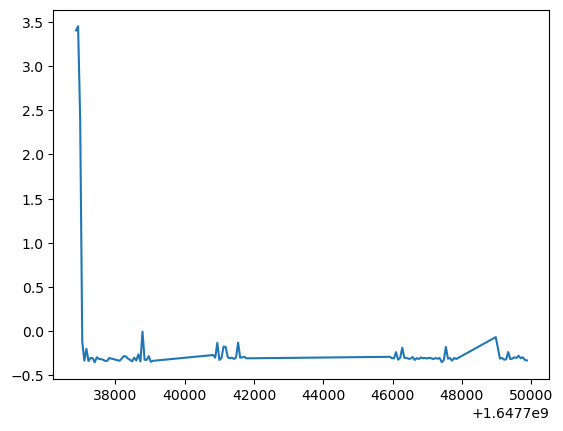

In [23]:
import matplotlib.pyplot as plt

plt.plot(t[0:100], plot_data[0:100])

## 服务故障修改

In [24]:
# 给定的Pod列表
pods = [
    "adservice-0", "adservice-1", "adservice-2", "adservice2-0",
    "cartservice-0", "cartservice-1", "cartservice-2", "cartservice2-0",
    "checkoutservice-0", "checkoutservice-1", "checkoutservice-2", "checkoutservice2-0",
    "currencyservice-0", "currencyservice-1", "currencyservice-2", "currencyservice2-0",
    "emailservice-0", "emailservice-1", "emailservice-2", "emailservice2-0",
    "frontend-0", "frontend-1", "frontend-2", "frontend2-0",
    "paymentservice-0", "paymentservice-1", "paymentservice-2", "paymentservice2-0",
    "productcatalogservice-0", "productcatalogservice-1", "productcatalogservice-2", "productcatalogservice2-0",
    "recommendationservice-0", "recommendationservice-1", "recommendationservice-2", "recommendationservice2-0",
    "shippingservice-0", "shippingservice-1", "shippingservice-2", "shippingservice2-0"
]

# 提取service-pod字典
service_pod_dict = {}

for pod in pods:
    # 提取服务名称（去掉最后的数字和可能的后缀）
    service_name = pod.rsplit('-', 1)[0]
    if service_name not in service_pod_dict:
        service_pod_dict[service_name] = []
    service_pod_dict[service_name].append(pod)

# 打印结果
for service, pod_list in service_pod_dict.items():
    print(f"{service}: {pod_list}")

adservice: ['adservice-0', 'adservice-1', 'adservice-2']
adservice2: ['adservice2-0']
cartservice: ['cartservice-0', 'cartservice-1', 'cartservice-2']
cartservice2: ['cartservice2-0']
checkoutservice: ['checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2']
checkoutservice2: ['checkoutservice2-0']
currencyservice: ['currencyservice-0', 'currencyservice-1', 'currencyservice-2']
currencyservice2: ['currencyservice2-0']
emailservice: ['emailservice-0', 'emailservice-1', 'emailservice-2']
emailservice2: ['emailservice2-0']
frontend: ['frontend-0', 'frontend-1', 'frontend-2']
frontend2: ['frontend2-0']
paymentservice: ['paymentservice-0', 'paymentservice-1', 'paymentservice-2']
paymentservice2: ['paymentservice2-0']
productcatalogservice: ['productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2']
productcatalogservice2: ['productcatalogservice2-0']
recommendationservice: ['recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2']
recommend

In [25]:
def process_service_fault(service):
    if "-" not in service:
        return ";".join(service_pod_dict[service])
process_service_fault("adservice")

'adservice-0;adservice-1;adservice-2'

In [28]:
def process_service_fault(service):
    if "-" not in service:
        return service_pod_dict[service][0]
    else:
        return service

def process_csv_file2(input_file, output_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)
    # 应用四舍五入函数到timestamp列
    df['root_cause_node'] = df['root_cause_node'].apply(process_service_fault)
    # 保存修改后的数据到新的CSV文件
    df.to_csv(output_file, index=False)

# 输入文件和输出文件路径
input_file = '/home/user/yjq/Dejavu-changed/data/aiops2022/gt/faults.csv'
output_file = '/home/user/yjq/Dejavu-changed/data/aiops2022/gt/faults.csv'

# 调用函数处理CSV文件
process_csv_file2(input_file, output_file)